# SANTANDER CASE - Data Scientist 

## c) Clustering

The third task is to find the three natural groups that have the highest expected profits per customer. That means the 3 groups that have the highest amount of unsatisfied customers

### In order to solve this problem, we are going to do the following steps:
- 1 Loading Data and Packeges;
- 2 Data Preparation;
    - 2.1 Dataset Split (train - test);
    - 2.2 Rebuilding the Selected Dataset;
    - 2.3 Feature Scaling;
- 3 Clusters Number;
    - 3.1 Elbow Method;
    - 3.2 Silhouette Method; 
- 4 Results Analysis;
- 5 Next steps;
- 6 References;

### 1 Loadgin Data and Packeges

In [111]:
# Loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

In [112]:
# Loading the Train and Test datasets
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

### 2 Data Preparation;

#### 2.2 Dataset Split (train - test)
As said in Part A, section 3, the train_test_split method does the segmentation at random, even with an extremely unbalanced dataset, the split should occur so that both training and testing have the same proportion of unsatisfied customers.  
**However, as it is difficult to guarantee randomness in fact, we can make a stratified split based on the TARGET variable and thus ensure that the proportion is exact in both datasets.**

In [113]:
from sklearn.model_selection import train_test_split

# Spliting the dataset on a proportion of 80% for train and 20% for test.
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('TARGET', axis = 1), df_train.TARGET, 
                                                    train_size = 0.8, stratify = df_train.TARGET,
                                                    random_state = 42)

#Checando o resultado do splot
X_train.shape, y_train.shape[0], X_test.shape, y_test.shape[0]

((60816, 370), 60816, (15204, 370), 15204)

#### 2.2 Rebuilding the selected dataset
Though it is a clustering problem, we could use the selected dataset for classification because it is much smaller than the full datasets, as well as it still robust and useful for clustering.

Here we need to: 
- Remove constant / semi-constat features;
- Remove dupplicated features;
- Selecting only the best 96 features that we found in Part A.

In [114]:
# Making copys of X_train and X_test to work with in this section
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

Remove constant and semi-constant features

In [115]:
# Investigating if there are constant or semi-constat feature in X_train
from sklearn.feature_selection import VarianceThreshold

# Removing all features that have variance under 0.01
selector = VarianceThreshold(threshold = 0.01)
selector.fit(X_train_clean)
mask_clean = selector.get_support()
X_train_clean = X_train_clean[X_train_clean.columns[mask_clean]]

Remove duplicated features

In [116]:
# Checking if there is any duplicated column
remove = []
cols = X_train_clean.columns
for i in range(len(cols)-1):
    column = X_train_clean[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(column, X_train_clean[cols[j]].values):
            remove.append(cols[j])


# If yes, than they will be dropped here
X_train_clean.drop(remove, axis = 1, inplace=True)

Selecting the 96 best features

In [117]:
# Selection the 96 best features aconrdingly to f_classif
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

selector_fc = SelectKBest(score_func = f_classif, k = 96)
selector_fc.fit(X_train_clean, y_train)
mask_selected = selector_fc.get_support()

# Saving the selected columns in a list
selected_col = X_train_clean.columns[mask_selected]

In [118]:
# Creating datasets where only with the selected 96 features are included
X_train_selected = X_train[selected_col]
X_test_selected = X_test[selected_col]

#### 2.3 Feature Scaling
Because the KMeans algorithm will be used, the difference in scales between the characteristics is a big problem for the model. The algorithm is based on distance calculation and therefore the data must be transformed to a standardized scale.

In [119]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

To scale the features, we will use Standard Scaling method. The feature will be scaled in the interval -1 and 1.

In [120]:
# Scaling the features using Standardization
scaled_features = StandardScaler().fit_transform(X_train_selected)

Now that we data ready, we can move forward to the next step.

### 3 Clusters Number

To work with KMeans algorithm, the most important part is to find the right value for K, that is, the number of natural clusters that exists on the data. 

#### 3.1 Elbow Method
To find the quantity of natural groups, that is, the K value, we can use the Ewbow method.

In this way, the value of K that is at the threshold between a large reduction in the sum of the variance calculated by the algorithm will be found, that is, where the graph literally forms an Elbow.

As we should find the 3 groups that have the highest  expected profits per customer, let's start this analysis considering that there are at least 6 clusters on the data.

In [146]:
# Appling the Elbow Method to find the best K value
wcss = []
 
for i in range(6, 50):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(scaled_features)
    print(i, kmeans.inertia_)
    wcss.append(kmeans.inertia_)  

6 796301.8824651258
7 783494.8558173988
8 695308.5103273552
9 640683.7168424049
10 621990.9095867214
11 597017.2867978826
12 596602.246671681
13 576914.3826084826
14 553528.1641014704
15 534698.321660184
16 501375.33716146497
17 503007.84483268345
18 501003.8345275152
19 474077.7137281408
20 462097.61550325813
21 431099.2915988232
22 448080.6663688069
23 442496.14892224554
24 419602.8784638212
25 426512.10790939495
26 405158.5808970191
27 400141.9105660133
28 418290.9624668453
29 391894.3418938859
30 367982.444243601
31 389762.6840380079
32 396771.8299579753
33 375344.2062524135
34 374698.49401560513
35 388320.5870030519
36 363174.684790794
37 372205.88745156495
38 364319.1452270452
39 339599.48037895956
40 379476.3903699342
41 350388.7503978911
42 340282.7542000913
43 342879.51629116916
44 348910.6594534445
45 352368.7096042317
46 349620.94109851215
47 330258.63295891916
48 338451.6393614388
49 331746.8998220919


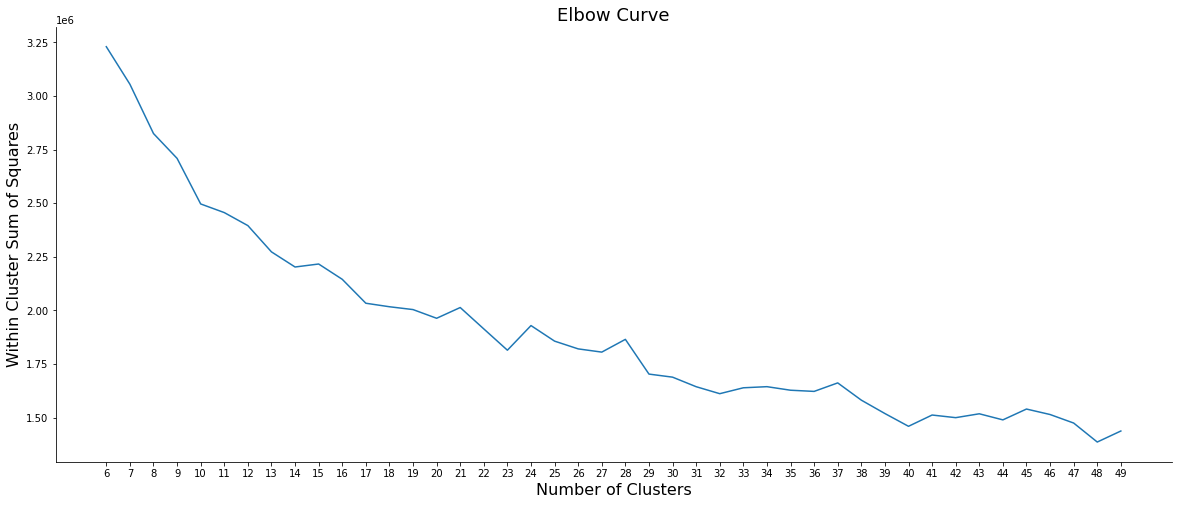

In [122]:
# Plotting the Elbow Curve
fig, ax = plt.subplots(figsize = (20, 8))
plt.plot(range(6, 50), wcss)
plt.title('Elbow Curve', fontsize = 18)
plt.xlabel('Number of Clusters', fontsize = 16)
plt.xticks(np.arange(6, 50, 1))
plt.ylabel('Within Cluster Sum of Squares', fontsize = 16) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Unfortunantly there is no evident elbow in the curve above. That means we are not able to the dertermine the best value of K using the Elbow Method. 

Let's try the Silhoutte method out.

#### 3.2 Silhouette Method
The silhouette method computes the silhouette coefficient for all samples. This coefficient is calculated using the mean intra-cluster distance (x) and the mean nearest-cluster distance (y) for each sample. It can be calculated so:

**Silhouette Coefficient = (y  -  x)  /  max(x,  y)**

Where:
- x is the mean intra cluster distance: mean distance betweent the points of the cluster and its center;
- y depicts mean nearest cluster distance i.e. mean distance to the instances of the next closest cluster.

The coefficient varies between -1 and 1. A value close to 1 implies that the instance is close to its cluster is a part of the right cluster. Whereas, a value close to -1 means that the value is assigned to the wrong cluster.

For this method we want to compute the silhouette score for each value of K and pick the highest value. 

In [123]:
from sklearn.metrics import silhouette_score

coefficients = []

for i in range(6, 50):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    coefficients.append(score)
    
    print("For K = {}, silhouette score is {})".format(i, score))

For K = 6, silhouette score is 0.39170129958169914)
For K = 7, silhouette score is 0.41304918803759033)
For K = 8, silhouette score is 0.41605867881981073)
For K = 9, silhouette score is 0.4179262824794158)
For K = 10, silhouette score is 0.4551295851372485)
For K = 11, silhouette score is 0.4584958607507717)
For K = 12, silhouette score is 0.4594058340111631)
For K = 13, silhouette score is 0.4603288397651356)
For K = 14, silhouette score is 0.4628869754615942)
For K = 15, silhouette score is 0.463278282099908)
For K = 16, silhouette score is 0.46278850822396794)
For K = 17, silhouette score is 0.4995700060883429)
For K = 18, silhouette score is 0.3938562789724567)
For K = 19, silhouette score is 0.466648112222931)
For K = 20, silhouette score is 0.5026848042765154)
For K = 21, silhouette score is 0.5018278696068378)
For K = 22, silhouette score is 0.5056714064169838)
For K = 23, silhouette score is 0.5063746331313971)
For K = 24, silhouette score is 0.5086291015102571)
For K = 25, si

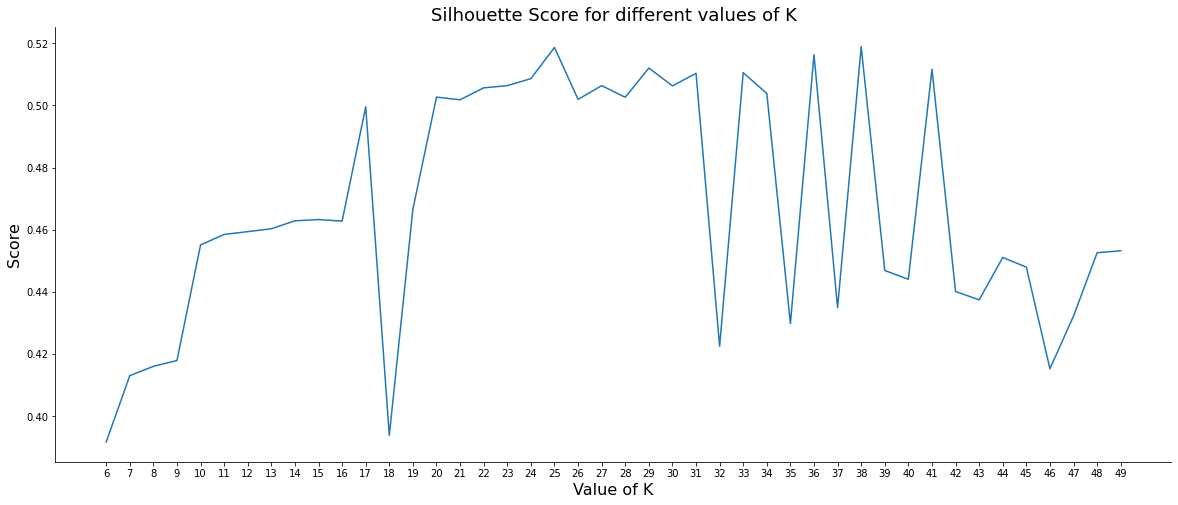

In [124]:
# Plotting the Elbow Curve
fig, ax = plt.subplots(figsize = (20, 8))
plt.plot(range(6, 50), coefficients)
plt.title('Silhouette Score for different values of K', fontsize = 18)
plt.xlabel('Value of K', fontsize = 16)
plt.xticks(np.arange(6, 50, 1))
plt.ylabel('Score', fontsize = 16) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

As we can see on the graph, the highest coefficient value (0.5186710574329028) is when K = 25. Since it is the highest score for K, we know that there is 31 natural clusters in this data and can now move forward to the next step.

### 4 Results Analysis

Finally, once it was defined that there should be 25 clusters, the 3 groups that generate the highest profit per customer are those that have the greatest proportion of unsatisfied customers, as the retention program is applied to a greater number of truly dissatisfied and generated customers. a lesser amount of false positives.

In [128]:
# Creating and training the KMeans model
kmeans = KMeans(n_clusters = 25).fit(scaled_features)

In [129]:
# Checking the labels
kmeans.labels_

array([ 6,  2,  1, ..., 22,  6,  1], dtype=int32)

Now, lets create a datafram only with the Target and the Label columns.

In [131]:
# Creating a Data DataFramer result analysis
result_train = pd.DataFrame({'target': y_train, 'labels': kmeans.labels_})

In [132]:
result_train.head()

,target,labels
56035,0,6
15449,0,2
68443,0,1
50258,0,6
4858,0,1


In order to get the relative proportion of unsatisfied customers in each clusters and plot them, we need firt to find this proportions.

In [133]:
# Get the distribution only for unsatisfied customer
unsatisfied_dist = result_train[result_train['target'] == 1].labels.value_counts().sort_index()

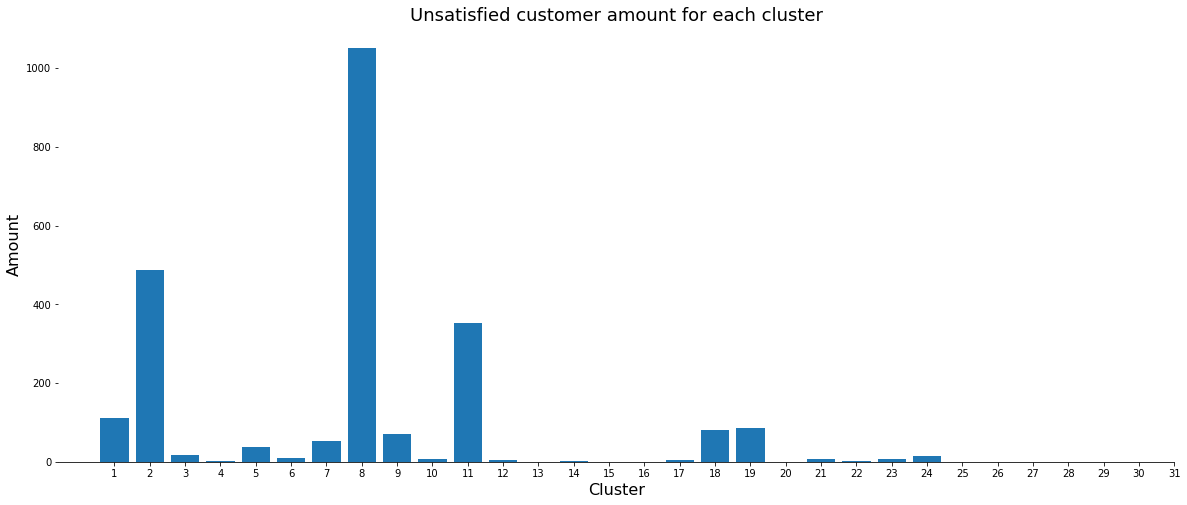

In [145]:
# Plotting the unsatified customers ditribution for the clusters
fig, ax = plt.subplots(figsize = (20, 8))
plt.bar(unsatisfied_dist.index + 1, unsatisfied_dist.values);
plt.title('Unsatisfied customer amount for each cluster', fontsize = 18);
plt.xlabel('Cluster', fontsize = 16);
plt.ylabel('Amount', fontsize = 16)
plt.xticks(range(1, 32, 1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

By analysing the above graph, we can conclude that the clusters 2, 8 and 11 have clearly the biggest numbers of unsatisfied customers. 

**Base on this fact, we can conclude that this three clusters have the highest profit per customer and we should start work on them in order to maximize effort and profit.**

This analysis was made on the train split part, we can also cluster the test split part (X_test) and check if the results macht as a form of double-check. 

In [136]:
scaled_features = StandardScaler().fit_transform(X_test_selected)
result_test = pd.DataFrame({'target': y_test, 'labels': kmeans.predict(scaled_features)})

In [137]:
result_test.head()

,target,labels
63089,0,7
27056,0,1
5923,0,1
4865,0,1
6344,0,6


In [142]:
# Get the distribution only for unsatisfied customer on X_test_selected
unsatisfied_dist_test = result_test[result_test['target'] == 1].labels.value_counts().sort_index()

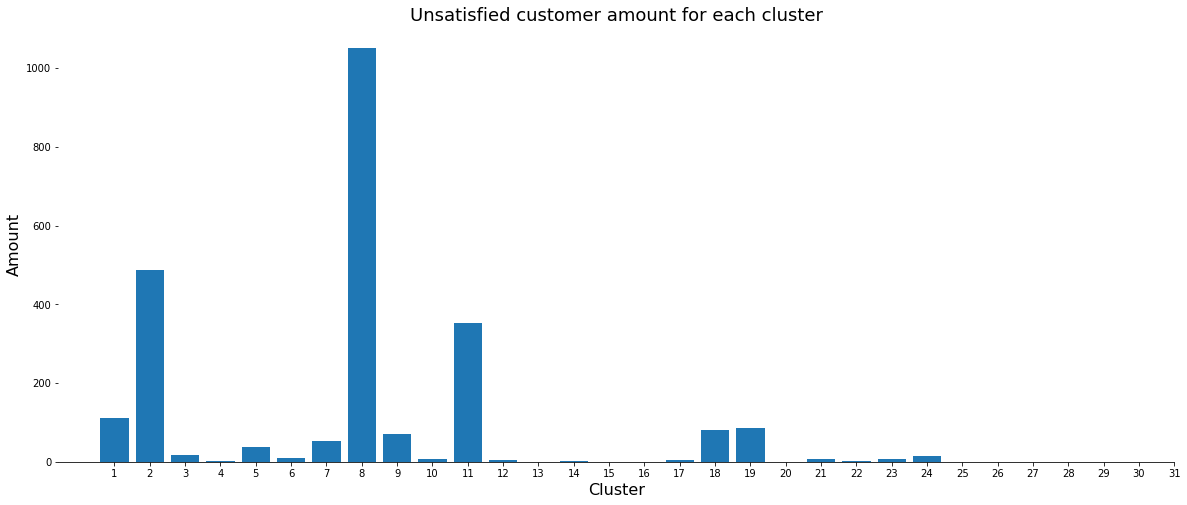

In [144]:
# Plotting the unsatified customers ditribution for the clusters
fig, ax = plt.subplots(figsize = (20, 8))
plt.bar(unsatisfied_dist.index + 1, unsatisfied_dist.values);
plt.title('Unsatisfied customer amount for each cluster', fontsize = 18);
plt.xlabel('Cluster', fontsize = 16);
plt.ylabel('Amount', fontsize = 16)
plt.xticks(range(1, 32, 1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

As expected, the clusters 2, 8 and 11 have the most part of unsatisfied customers. It is a clear evidence that our model performs well for new instances!

**So this is the end of the Case Problem made together with Santander. We have optimized models for Classification, for NPS and Clustering the unsatisfied customers and having all those resources we can maximize the profit as well as to get a deeper understanding of the level of satisfaction of each customer!**

### 5 Next steps

For further iterations on this project in order to improve the analysis and the results, I would suggest 3 main points:

- As Caio Martins (https://github.com/CaioMar/) did and suggested me, a nice improvement would be to create a function that calculates the total profit. It is possible once we have values for TP and FP. So we could precise the amount of money we will spare by using this NPS system as a double check method for applying the retention program.
- Another improvement is to try out others cluster algorithm like Agglomerative Hierarchical Clustering.

### 6 References
[1] Banerjee. Prashant, Comprehensive Guide on Feature Selection., https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection  
[2] D. Beniaguev., Advanced Feature Exploration. https://www.kaggle.com/selfishgene/advanced-feature-exploration  
[3] M. Filho., A forma mais simples de selecionar as melhores variáveis usando Scikit-learn. https://www.youtube.com/watch?v=Bcn5e7LYMhg&t=2027s  
[4] M. Filho., Como Remover Variáveis Irrelevantes de um Modelo de Machine Learning, https://www.youtube.com/watch?v=6-mKATDSQmk&t=1454s  
[5] M. Filho., Como Tunar Hiperparâmetros de Machine Learning Sem Perder Tempo, https://www.youtube.com/watch?v=WhnkeasZNHI  
[6] G. Caponetto., Random Search vs Grid Search for hyperparameter optimization, https://towardsdatascience.com/random-search-vs-grid-search-for-hyperparameter-optimization-345e1422899d  
[7] A. JAIN., Complete Guide to Parameter Tuning in XGBoost with codes in Python, https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ 
[8] How to plot ROC curve in Python, https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python  
[9] F. Santana., Algoritmo K-means: Aprenda essa Técnica Essêncial através de Exemplos Passo a Passo com Python, https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/  
[10] A. Géron., Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, Alta Books, Rio de Janeiro, 2019, 516 p.  
[11] W. McKinney., Python for data analysis, Novatec Editora Ltda, São Paulo, 2019, 613 p.  